In [9]:
import os
import torch
import PIL
from torch import nn
from torch.utils.data.dataloader import default_collate
import pickle
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils

#ACTUALLY needed for OUR PROJECT
import pickle
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device:',device)

# Set a random seed for everything important
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = False

# Set a seed with a random integer, in this case, I choose my verymost favourite sequence of numbers
seed_everything(123)

Using device: mps


In [10]:
class TumorDataset(torch.utils.data.Dataset): 
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx): 
        target = torch.tensor(self.data[idx][0], dtype=torch.long)  # Ensure target is long for classification
        image = torch.tensor(self.data[idx][1], dtype=torch.float32)  # Convert image to float32
        return image, target

    def __len__(self):
        return len(self.data)  # Use len() instead of shape[0] for lists

def collate_fn(batch):
    return tuple(x_.to(device) for x_ in default_collate(batch))

def get_dataset(test_size, val_size, v=True): 
    with open("dataset.pkl", "rb") as f: 
        rawdata = pickle.load(f)
    
    mean = np.mean(np.stack(rawdata[:,1]))
    std = np.std(np.stack(rawdata[:,1]))

    rawdata[:,1]  = (rawdata[:,1] - mean)/std
    
    labels = {
        "Not cancer": 0, 
        "Cancer": 1
    }

    dataset = TumorDataset(data=rawdata)

    test_amount, val_amount = int(dataset.__len__() * test_size), int(dataset.__len__() * val_size)

    # this function will automatically randomly split your dataset but you could also implement the split yourself
    train_set, test_set = torch.utils.data.random_split(dataset, [
                (dataset.__len__() - (test_amount)), 
                test_amount, 
    ])
    
    print(f"There are {len(train_set)} examples in the training set")
    print(f"There are {len(test_set)} examples in the test set \n")
    print(f"Image shape is: {train_set[0][0].shape}, label example is {train_set[0][1]}")
    
    return train_set, test_set

train_set, test_set = get_dataset(test_size=0.15, val_size=0)

# Make dataloaders
batch_size=16

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

There are 3910 examples in the training set
There are 690 examples in the test set 

Image shape is: torch.Size([128, 128]), label example is 0


In [11]:
class VGG16(torch.nn.Module):
    def __init__(self, num_classes, in_channels=1, features_fore_linear=25088, dataset=None, learning_rate = 1e-4, final_layer = 4096):
        super().__init__()
        
        # Helper hyperparameters to keep track of VGG16 architecture
        pool_stride = 2
        conv_kernel = 3
        pool_kernel = 2
        dropout_probs = 0.5
        optim_momentum = 0.9
        weight_decay = 5e-4

        # Define features and classifier each individually, this is how the VGG16-D model is orignally defined
        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=conv_kernel, padding=1), 
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=conv_kernel, padding=1), 
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=conv_kernel),
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=conv_kernel),
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=conv_kernel),
            nn.BatchNorm2d(256),  # Batch Normalization
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel),
            nn.BatchNorm2d(256),  # Batch Normalization
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=conv_kernel),
            nn.BatchNorm2d(256),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),
        ).to(device)
        
        self.classifier = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=features_fore_linear, out_features=final_layer),
            nn.ReLU(),
            nn.Dropout(p=dropout_probs),
            nn.Linear(in_features=final_layer, out_features=final_layer),
            nn.ReLU(),
            nn.Dropout(p=dropout_probs),
            nn.Linear(in_features=final_layer, out_features=num_classes),
        ).to(device)
        
        # In the paper, they mention updating towards the 'multinomial logistic regression objective'
        # As can be read in Bishop p. 159, taking the logarithm of this equates to the cross-entropy loss function.
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer - For now just set to Adam to test the implementation
        self.optim = torch.optim.Adam(list(self.features.parameters()) + list(self.classifier.parameters()), lr=learning_rate)
        #self.optim = torch.optim.SGD(list(self.features.parameters()) + list(self.classifier.parameters()), lr=learning_rate, momentum=optim_momentum, weight_decay=weight_decay)

        self.dataset = dataset

    def forward(self, x):
        x = x.unsqueeze(1)
        return self.classifier(self.features(x))

    def train_model(self, train_dataloader, epochs=1, val_dataloader=None):
        
        # Call .train() on self to turn on dropout
        self.train()

        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()
        
                self.optim.step()
                self.optim.zero_grad()

                # Keep track of training accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()
            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            # If val_dataloader, evaluate after each epoch
            if val_dataloader is not None:
                # Turn off dropout for testing
                self.eval()
                acc = self.eval_model(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}, train accuracy: {epoch_acc / len(train_dataloader.dataset)}")
                # turn on dropout after being done
                self.train()
        
        return train_accs, test_accs

    def eval_model(self, test_dataloader):
        
        self.eval()
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            logits = self(input_batch)

            total_acc += (torch.argmax(logits, dim=1) == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc

    def predict(self, img_path):
        img = PIL.Image.open(img_path)
        img = self.dataset.dataset.transform(img)
        classification = torch.argmax(self(img.unsqueeze(dim=0)), dim=1)
        return img, classification
    
    def predict_random(self, num_predictions=16):
        """
        Plot random images from own given dataset
        """
        random_indices = np.random.choice(len(self.dataset)-1, num_predictions, replace=False)
        classifcations = []
        labels = []
        images = []
        for idx in random_indices:
            img, label = self.dataset.__getitem__(idx)
            device = next(self.parameters()).device  # Get model's device
            img = img.to(device).unsqueeze(0)  # Ensure correct shape: (1, C, H, W)
            # Move image to same device
            
            classifcation = torch.argmax(self(img), dim=1)

            classifcations.append(classifcation)
            labels.append(label)
            images.append(img)

        return classifcations, labels, images

def get_vgg_weights(model):
    """
    Loads VGG16-D weights for the classifier to an already existing model
    Also sets training to only the classifier
    """
    # Load the complete VGG16 model
    temp = torchvision.models.vgg16(weights='DEFAULT')

    # Get its state dict
    state_dict = temp.state_dict()

    # Change the last layer to fit our, smaller network
    state_dict['classifier.6.weight'] = torch.randn(10, 4096)
    state_dict['classifier.6.bias'] = torch.randn(10)

    # Apply the state dict and set the classifer (layer part) to be the only thing we train
    model.load_state_dict(state_dict)

    for param in model.features.parameters():
        param.requires_grad = False

    model.optim = torch.optim.Adam(model.classifier.parameters())


    return model

In [ ]:

def objective_function(x: list):
    learning_rate = x[0]
    final_layer = x[1]
    in_channels = 1
    CNN_model = VGG16(num_classes=2, in_channels=in_channels, features_fore_linear=36864, dataset=test_set, learning_rate=learning_rate, final_layer=final_layer) 
    
    train_epochs = 
    train_accs, val_accs = CNN_model.train_model(train_dataloader, epochs=train_epochs)
    acc = CNN_model.eval_model(test_dataloader)
    
    return - acc


In [17]:
from skopt import gp_minimize

learning_rate = (1e-5, 1e-3)
final_layer = (3000, 6000)
x0 = [np.random.uniform(learning_rate[0], learning_rate[1]), np.random.randint(final_layer[0], final_layer[1])]
# y0 = objective_function(x0)


opt = gp_minimize(objective_function,
            [learning_rate, final_layer],
            acq_func= "EI",
            n_initial_points= 0,
            n_calls= 2,
            x0= [x0,],
            xi= 0.1
            )


  0%|          | 0/245 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [14]:
in_channels = 1#next(iter(train_dataloader))[0].shape[1]
in_width_height = next(iter(train_dataloader))[0].shape[-1]
# Make a dummy model to find out the size before the first linear layer
CNN_model = VGG16(num_classes=2, in_channels=in_channels)

#Finding the correct n features for first linear layer: 
dummy_input = torch.randn(1, in_channels, in_width_height, in_width_height).to(device)
dummy_output = CNN_model.features(dummy_input)
n_features = dummy_output.shape[1]

# Now make true model when we know how many features we have before the first linear layer
CNN_model = VGG16(num_classes=2, in_channels=in_channels, features_fore_linear=36864, dataset=test_set) 

train_epochs = 1
train_accs, test_accs = CNN_model.train_model(train_dataloader, epochs=train_epochs)

with open("train_accs.pkl", "wb") as f: 
    pickle.dump(train_accs, f)

with open("test_accs.pkl", "wb") as f: 
    pickle.dump(test_accs, f)

torch.save(CNN_model.state_dict(), "weights1.pth")

  0%|          | 0/245 [00:09<?, ?it/s]


KeyboardInterrupt: 

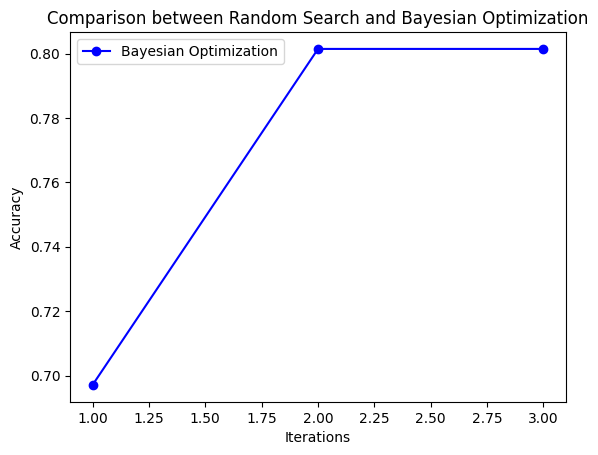

array([0.69710145, 0.80144928, 0.80144928])

In [34]:
y_bo = np.maximum.accumulate(-opt.func_vals).ravel()
# define iteration number
xs = np.arange(1,4,1)

# plt.plot(xs, 0, 'o-', color = 'red', label='Random Search')
plt.plot(xs, y_bo, 'o-', color = 'blue', label='Bayesian Optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Comparison between Random Search and Bayesian Optimization')
plt.show()

y_bo

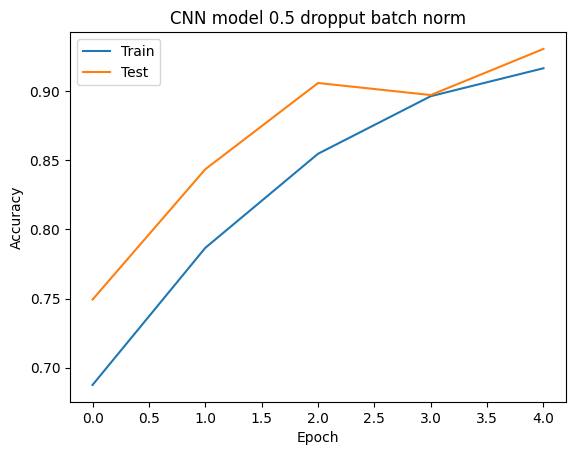

In [ ]:
# Load test accuracies
train_epochs = 5
with open('test_accs.pkl', 'rb') as test_accs_file:  # 'rb' for read-binary mode
    test_accs = pickle.load(test_accs_file)

# Load train accuracies
with open('train_accs.pkl', 'rb') as train_accs_file:  # 'rb' for read-binary mode
    train_accs = pickle.load(train_accs_file)

plt.plot(range(train_epochs), train_accs, label='Train')
plt.plot(range(train_epochs), test_accs, label='Test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN model 0.5 dropput batch norm')
plt.legend()
plt.show()

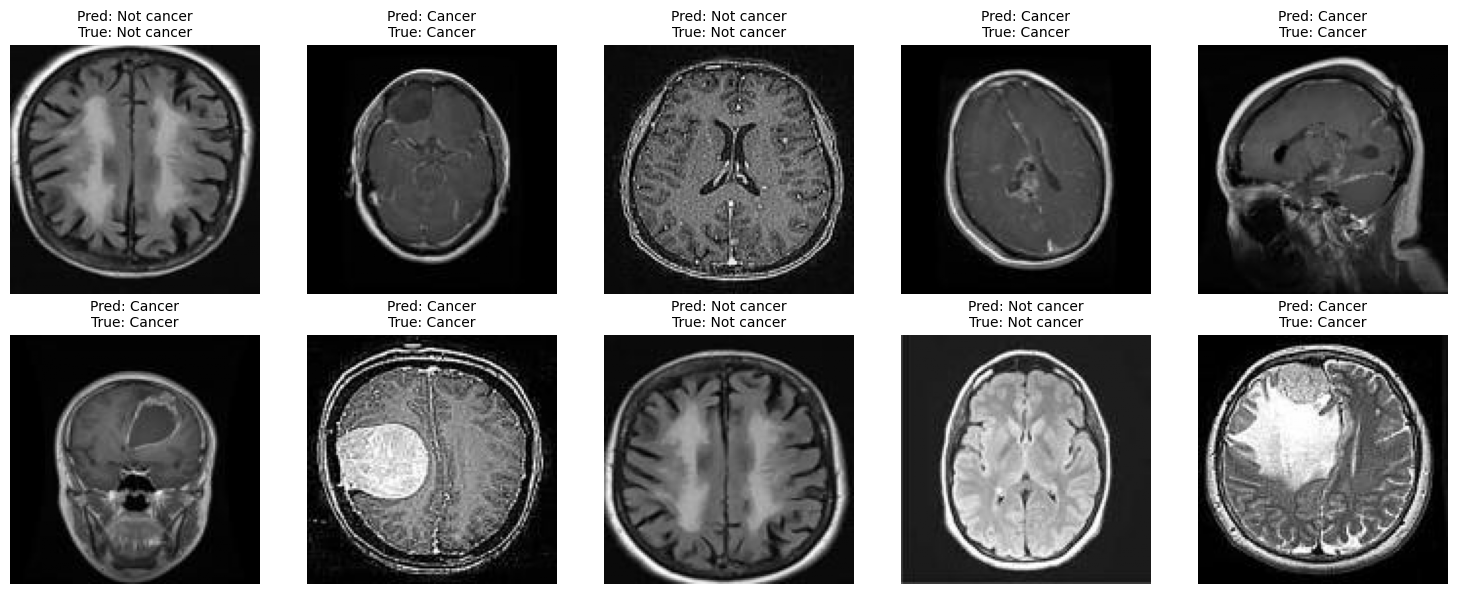

In [ ]:
n_channels = 1#next(iter(train_dataloader))[0].shape[1]
in_width_height = next(iter(train_dataloader))[0].shape[-1]
# Make a dummy model to find out the size before the first linear layer
CNN_model = VGG16(num_classes=2, in_channels=in_channels)

#Finding the correct n features for first linear layer: 
dummy_input = torch.randn(1, in_channels, in_width_height, in_width_height).to(device)
dummy_output = CNN_model.features(dummy_input)
n_features = dummy_output.shape[1]

# Now make true model when we know how many features we have before the first linear layer
CNN_model = VGG16(num_classes=2, in_channels=in_channels, features_fore_linear=36864, dataset=test_set) 
CNN_model.load_state_dict(torch.load('weights1.pth', weights_only=True,map_location=torch.device(device)))

c_map = {0: "Not cancer", 
            1: "Cancer"}
CNN_model.eval()

classifications, labels, images = CNN_model.predict_random(num_predictions=10)

def unnormalize_image(img, mean, std):
    """Convert normalized image tensor to displayable format."""
    img = img * std + mean  # Reverse normalization
    img = img.clamp(0, 1)  # Clamp to valid image range [0, 1]
    return img.permute(1, 2, 0)  # Move channels to the last dimension for display

# Plot images with labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust grid to match number of images
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < len(images):
        # Unnormalize and plot the image
        img = (images[idx]).permute(1, 2, 0) 
        img = img.cpu().numpy() 
        ax.imshow(img, cmap="gray")
        ax.axis('off')
        # Display predicted and true labels
        ax.set_title(f"Pred: {c_map[int(classifications[idx])]}\nTrue: {c_map[int(labels[idx])]}", fontsize=10)
        
    else:
        ax.axis('off')  # Turn off extra axes

plt.tight_layout()
plt.show()